# RenAIssance: OCR for Seventeenth Century Spanish Texts

## Description
RenAIssance aims to utilize optical character recognition (OCR) to digitize text sources not yet addressed by current tools. The project leverages machine learning techniques to enable OCR on various undigitized materials. Specifically, it focuses on AI applications to recognize text in seventeenth-century Spanish printed sources, a niche largely ignored by existing OCR solutions.

Current OCR tools, like Adobe Acrobat’s OCR, struggle with transliteration from historical texts. These tools can recognize text from modern, clearly printed sources but fail with early print forms and manuscripts.

<p align="center">
<img src="https://github.com/ML4SCI/DeepLearnHackathon/blob/Renaissance/NLPRenaissanceChallenge/images/book_header.png?raw=true">
</p>

## Task
Develop a model using Convolutional-Recurrent Neural Network architectures to recognize text in the provided image dataset. Choose the best approach and explain your strategy.

<p align="center">
<img src="https://github.com/ML4SCI/DeepLearnHackathon/blob/Renaissance/NLPRenaissanceChallenge/images/crnn_architecture.png?raw=true">
</p>


## Dataset
- A diverse collection of printed texts from the seventeenth century.

## Evaluation Metrics
Outline the evaluation metrics used to assess your model's performance. Consider the following:
- Character Error Rate (CER)
- Word Error Rate (WER)
- Precision, Recall, and F1 Score for text recognition

## Deliverables
- A trained OCR model that can recognize text in the given datasets.
- A concise report detailing the chosen approach, model architecture, training process, and evaluation outcomes.
- An example notebook showcasing the model's performance on sample data.

# Installing necessary packages, can ask the users to restart the notebook

In [1]:
!pip install scikit-image PyMuPDF python-docx opencv-python scipy torch torchvision==0.2.1 pillow==8.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 17.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10

You will be prompted to Restart the session. Continue running the cells after restarting

# Importing the necessary modules

In [1]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import string
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

# Downloading the dataset

In [2]:
# Downloading the Dataset on collab/local notebook
!gdown http://drive.google.com/uc?id=10NX_UbV2HMbPEO2fvKYAIXOOOec0g38g  # Downloading link for Ancient Text
!gdown http://drive.google.com/uc?id=1YTaqNoZCYP74AuQxlyJsiQLhcoc8DNSv  # Downloading link for Ground Truth Text

Downloading...
From: http://drive.google.com/uc?id=10NX_UbV2HMbPEO2fvKYAIXOOOec0g38g
To: /content/Padilla - Nobleza virtuosa_testExtract.pdf
100% 2.58M/2.58M [00:00<00:00, 174MB/s]
Downloading...
From: http://drive.google.com/uc?id=1YTaqNoZCYP74AuQxlyJsiQLhcoc8DNSv
To: /content/Padilla - 1 Nobleza virtuosa_testTranscription.docx
100% 29.1k/29.1k [00:00<00:00, 52.4MB/s]


In [3]:
!ls

'Padilla - 1 Nobleza virtuosa_testTranscription.docx'   sample_data
'Padilla - Nobleza virtuosa_testExtract.pdf'


# Utility Functions

In [4]:
def count_files_in_folder(folder_path, extensions_list):
    # Initialize counter for files
    file_count = 0

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file ends with the given file extension
        for extension in extensions_list:
            if filename.lower().endswith(extension):
                file_count += 1

    return file_count

# Pre-processing the dataset

### Converting PDF to images

In [5]:
def pdf_to_images(pdf_path, output_folder):
    # Open the PDF
    pdf_document = fitz.open(pdf_path)

    # Iterate over each page in the PDF
    for page_number in range(len(pdf_document)):
        # Get the page
        page = pdf_document.load_page(page_number)

        # Render the page as a Pixmap
        pixmap = page.get_pixmap()

        # Save the Pixmap as a PNG image
        image_path = os.path.join(output_folder, f'page_{page_number + 1}.png')
        pixmap.save(image_path)

    # Close the PDF
    pdf_document.close()

pdf_path = "./Padilla - Nobleza virtuosa_testExtract.pdf"  # Path to your PDF file
output_folder = "./imgsUnProcessed"  # Output folder to save the images
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
pdf_to_images(pdf_path, output_folder)

### Splitting two sided scanned images into individual pages.

In [6]:
#Segregating 2-sided pages into individual pages

def split_and_save_image(image_path, output_folder, last_image_number):
    # Read the image
    img = cv2.imread(image_path)

    # Get image width
    _, width, _ = img.shape

    # You can alter these, to get the optimum values for both
    width_for_single_page, width_for_dual_pages = 350, 450

    # Determine filename based on width and last image number
    if width < width_for_single_page:
        filename = f"image_{last_image_number}.png"
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, img)
        last_image_number += 1

    elif width > width_for_dual_pages:
        left_half = img[:, :width // 2]
        right_half = img[:, width // 2:]
        filename = f"image_{last_image_number}.png"
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, left_half)
        last_image_number += 1
        filename = f"image_{last_image_number}.png"
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, right_half)
        last_image_number += 1

    return last_image_number

def process_images(image_folder, output_folder):
    # Initialize image counter, starting from 1
    last_image_number = 1

    # Iterate through all files in the image folder
    for indx in range(count_files_in_folder(image_folder, [".png", ".jpg", ".jpeg"])):
        # Check for image files only
        filename = 'page_' + str(indx+1) + '.png'
        image_path = os.path.join(image_folder, filename)
        last_image_number = split_and_save_image(image_path, output_folder, last_image_number)

image_folder = "./imgsUnProcessed"
output_folder = "./imgsForAllPages"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_images(image_folder, output_folder)
print("Image processing complete!")

Image processing complete!


In [7]:
!git clone https://github.com/Shashankss1205/HumanAI.git

Cloning into 'HumanAI'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 57 (delta 9), reused 24 (delta 6), pack-reused 24
Receiving objects: 100% (57/57), 75.48 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# Text Detection
### Extracting words from a scanned text page image can be achieved using [CRAFT Model](https://github.com/clovaai/CRAFT-pytorch). (Ths will take 3-4 mins to process the entire model)

In [8]:
#It generally takes about ~3-4 mins
!python3 /content/HumanAI/OCR/CRAFT/BoundBoxFunc/test.py --trained_model='/content/HumanAI/OCR/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth'

Loading weights from checkpoint (/content/HumanAI/OCR/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth)
elapsed time : 144.20789647102356s


### The output of this model provides coordinates of the polygon enclosing the word. Using these coordinates one can draw a bounding box and crop word images.

In [9]:
#Sorting the BB based on the Spanish writing style

# Function to process bounding boxes
def process_bounding_boxes(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Parse bounding box coordinates
    bounding_boxes = []
    for line in lines:
        coords = list(map(int, line.strip().split(',')))
        bounding_boxes.append(coords)

    # Sort bounding boxes based on y_min value
    bounding_boxes.sort(key=lambda box: box[1])

    vertical_distance_between_lines = 10   #Change it according to the dataset, you are using
    # Group bounding boxes based on difference between max and min y_min values
    grouped_boxes = []
    current_group = []
    for box in bounding_boxes:
        if not current_group:
            current_group.append(box)
        else:
            min_y = min(current_group, key=lambda x: x[1])[1]
            max_y = max(current_group, key=lambda x: x[1])[1]
            if box[1] - min_y <= vertical_distance_between_lines:
                current_group.append(box)
            else:
                grouped_boxes.append(current_group)
                current_group = [box]

    # Append the last group
    if current_group:
        grouped_boxes.append(current_group)

    # Sort each group based on x_min value
    for group in grouped_boxes:
        group.sort(key=lambda box: box[0])

    return grouped_boxes

# Path to the directory containing text files
input_directory = "./BoundBoxApplied"
output_directory = "./BoundBoxSorted"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over each text file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_directory, filename)
        sorted_bounding_boxes = process_bounding_boxes(file_path)

        # Write sorted bounding boxes to text file in output directory
        output_file_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}_sorted.txt")
        with open(output_file_path, "w") as outfile:
            for group in sorted_bounding_boxes:
                for box in group:
                    outfile.write(','.join(map(str, box)) + '\n')
                outfile.write((';'))

### We need to extract all the words from .docx file containing Transcription (True lables).

In [10]:
#ground truth to text code

# def remove_punctuation(text):
#     # Define a translation table that maps punctuations to None
#     translation_table = str.maketrans("", "", string.punctuation)
#     # Remove punctuations using translate() method
#     return text.translate(translation_table)

def save_pages_to_text(docx_file, output_file):
    document = Document(docx_file)
    all_text = ""
    for paragraph in document.paragraphs:
        text = paragraph.text.strip()
        # Remove punctuations from the text before appending to the all_text variable
        # text_without_punctuation = remove_punctuation(text)
        # Check if the line starts with "PDF p"
        if not text.startswith("PDF p"):
            all_text += text + "\n"

    # Write all_text to the output file
    with open(output_file, "w") as file:
        file.write(all_text)

# Usage:
docx_file = "/content/Padilla - 1 Nobleza virtuosa_testTranscription.docx"
output_file = "/content/all_text.txt"     # File where the text will be saved
save_pages_to_text(docx_file, output_file)

### Since we have processed our text book into individual pages, we need to split the entire transcription based on text pages.

In [11]:
#splitting text files, based on the text

def count_occurrences_of_semicolon(filename):
    with open(filename, 'r') as file:
        content = file.read()
        return content.count(';')

def read_nth_line(file_path, n):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i == n - 1:
                return line.rstrip('\n')  # Remove newline character from the end of the line
    return None

def process_textfiles(textfile, sorted_BoundBox_folder, output_folder):
  # Initialize textfile counter, starting from 1
  last_textfile_number = 7
  print(str(count_files_in_folder(sorted_BoundBox_folder,['.txt'])) + ' files in the folder')
  # Iterate through all files in the textfile folder
  for indx in range(count_files_in_folder(sorted_BoundBox_folder, ['.txt'])-6):   # 6 pages left for testing
    # Check for textfile files only
    filename = 'res_image_' + str(indx+1) + '_sorted.txt'
    output_file = os.path.join(output_folder, 'res_image_' + str(indx+1) + '_actual.txt')
    res_image_sorted_path = os.path.join(sorted_BoundBox_folder, filename)
    occurrences = count_occurrences_of_semicolon(res_image_sorted_path) - 2
    with open(output_file, 'w') as output:
        for eachline in range(occurrences):
            content = read_nth_line(textfile, eachline+last_textfile_number)
            output.write(content + '\n')
    last_textfile_number = last_textfile_number + occurrences

textfile = '/content/all_text.txt'
sorted_BoundBox_folder = '/content/BoundBoxSorted'
output_folder = "/content/textSplitted"  # Replace with your output folder path
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_textfiles(textfile, sorted_BoundBox_folder, output_folder)
print("Text splitting complete!")


31 files in the folder
Text splitting complete!


### Extracts and saves bounding boxes from images using text data for filenames, skipping the last 6 images for testing.

In [12]:
def extract_bounding_boxes(image_path, bounding_boxes_file, text_file, output_folder):
    # Read the main image
    main_image = cv2.imread(image_path)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read bounding box coordinates from the text file
    with open(bounding_boxes_file, 'r') as f:
        bounding_boxes_data = f.read().split(';')
    bounding_boxes_data = bounding_boxes_data[1:]
    print(bounding_boxes_data) #first value is for page number so skip it
    # Read text data from the text file
    with open(text_file, 'r') as f:
        text_data = f.read().split('\n')
    print(text_data)

    for indx in range(len(text_data)):
        words = text_data[indx].split(' ')
        print(words)
        bounding_box_coords = bounding_boxes_data[indx].strip().split('\n')
        print(bounding_box_coords)
        for cnt in range(min(len(words),len(bounding_box_coords))):
            coordinates_list = [int(coord) for coord in bounding_box_coords[cnt].split(',')]
            x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max = coordinates_list

            # Extract the bounding box from the main image
            bounding_box = main_image[y_min:y_max, x_min:x_max]

            # Save the bounding box as a separate image
            output_path = os.path.join(output_folder, f'{words[cnt]}.png')
            cv2.imwrite(output_path, bounding_box)

            print(f'Saved bounding box for "{words[cnt]}" as {output_path}')

def apply_extraction_to_folder(image_folder, bounding_box_folder, text_folder, output_folder):
    # Iterate over each image in the image folder
    # for image_filename in os.listdir(image_folder):
    for image in range(count_files_in_folder(image_folder, ['.png', '.jpeg', '.jpg'])- 6): #last 6 pages are for testing
        image_filename = 'image_' + str(image+1) + '.png'
        if image_filename.endswith('.png') or image_filename.endswith('.jpg'):
            # Get the shared number before the extension
            image_base_name = os.path.splitext(image_filename)[0]
            bounding_box_filename = "res_" + image_base_name + '_sorted.txt'
            text_filename = "res_" + image_base_name + '_actual.txt'
            # Check if the corresponding bounding box file exists
            bounding_box_path = os.path.join(bounding_box_folder, bounding_box_filename)
            actual_text_path = os.path.join(text_folder, text_filename)
            if os.path.exists(bounding_box_path):
                image_path = os.path.join(image_folder, image_filename)
                # Apply bounding box extraction to each image
                extract_bounding_boxes(image_path, bounding_box_path, actual_text_path, output_folder)
            else:
                print(f'Bounding box file for {image_filename} does not exist.')

# Example usage
image_folder = '/content/imgsForAllPages'
bounding_box_folder = '/content/BoundBoxSorted'
text_folder = '/content/textSplitted'
# !mkdir output
output_folder = '/content/output'
apply_extraction_to_folder(image_folder, bounding_box_folder, text_folder, output_folder)

['33,48,217,48,217,68,33,68\n', '33,74,58,74,58,92,33,92\n66,73,102,73,102,90,66,90\n109,72,220,74,219,95,109,93\n', '32,100,60,100,60,116,32,116\n62,96,98,96,98,113,62,113\n100,96,108,96,108,112,100,112\n109,96,130,96,130,112,109,112\n132,96,165,96,165,117,132,117\n192,97,220,97,220,117,192,117\n', '32,120,93,120,93,134,32,134\n100,120,126,120,126,133,100,133\n130,121,164,118,166,135,132,138\n169,117,217,117,217,132,169,132\n', '32,136,76,136,76,152,32,152\n81,136,109,140,107,155,79,151\n108,140,134,140,134,152,108,152\n140,137,158,137,158,152,140,152\n164,138,174,138,174,152,164,152\n174,136,212,136,212,157,174,157\n', '53,160,78,160,78,173,53,173\n80,160,105,160,105,176,80,176\n103,158,147,153,149,171,105,176\n150,157,200,157,200,176,150,176\n', '73,180,96,180,96,192,73,192\n97,176,112,176,112,192,97,192\n113,176,158,176,158,192,113,192\n161,177,177,177,177,192,161,192\n', '96,194,156,196,155,213,95,211\n', '112,229,134,229,134,242,112,242\n137,230,152,230,152,242,137,242\n154,230,1

###  Extracts and saves bounding boxes from images using a numeric counter for filenames, skipping the first 25 images.

In [13]:
def extract_bounding_boxes(image_path, bounding_boxes_file, output_folder, word):
    # Read the main image
    main_image = cv2.imread(image_path)
    print(image_path)
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read bounding box coordinates from the text file
    with open(bounding_boxes_file, 'r') as f:
        bounding_boxes_data = f.read().split(';')
    bounding_boxes_data = bounding_boxes_data[1:]

    for indx in range(len(bounding_boxes_data)-1):
        bounding_box_coords = bounding_boxes_data[indx].strip().split('\n')
        for cnt in range(len(bounding_box_coords)):
            coordinates_list = [int(coord) for coord in bounding_box_coords[cnt].split(',')]
            x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max = coordinates_list

            # Extract the bounding box from the main image
            bounding_box = main_image[y_min:y_max, x_min:x_max]

            # Save the bounding box as a separate image
            output_path = os.path.join(output_folder, f'{word}.png')
            cv2.imwrite(output_path, bounding_box)

            print(f'Saved bounding box for "{word}" as {output_path}')
            word += 1

    return word

def apply_extraction_to_folder(image_folder, bounding_box_folder, output_folder, word):
    for image in range(count_files_in_folder(image_folder, ['.png', '.jpeg', '.jpg']) - 25):
        image_filename = 'image_' + str(image+26) + '.png'
        if image_filename.endswith('.png') or image_filename.endswith('.jpg'):
            image_base_name = os.path.splitext(image_filename)[0]
            print(image_base_name)
            bounding_box_filename = "res_" + image_base_name + '_sorted.txt'
            bounding_box_path = os.path.join(bounding_box_folder, bounding_box_filename)
            if os.path.exists(bounding_box_path):
                image_path = os.path.join(image_folder, image_filename)
                word = extract_bounding_boxes(image_path, bounding_box_path, output_folder, word)
            else:
                print(f'Bounding box file for {image_filename} does not exist.')

# image_folder = '/content/BoundBoxApplied'
image_folder = '/content/imgsForAllPages'
bounding_box_folder = '/content/BoundBoxSorted'
word = 0
output_folder = '/content/outputTest'
apply_extraction_to_folder(image_folder, bounding_box_folder, output_folder, word)

image_26
/content/imgsForAllPages/image_26.png
Saved bounding box for "0" as /content/outputTest/0.png
Saved bounding box for "1" as /content/outputTest/1.png
Saved bounding box for "2" as /content/outputTest/2.png
Saved bounding box for "3" as /content/outputTest/3.png
Saved bounding box for "4" as /content/outputTest/4.png
Saved bounding box for "5" as /content/outputTest/5.png
Saved bounding box for "6" as /content/outputTest/6.png
Saved bounding box for "7" as /content/outputTest/7.png
Saved bounding box for "8" as /content/outputTest/8.png
Saved bounding box for "9" as /content/outputTest/9.png
Saved bounding box for "10" as /content/outputTest/10.png
Saved bounding box for "11" as /content/outputTest/11.png
Saved bounding box for "12" as /content/outputTest/12.png
Saved bounding box for "13" as /content/outputTest/13.png
Saved bounding box for "14" as /content/outputTest/14.png
Saved bounding box for "15" as /content/outputTest/15.png
Saved bounding box for "16" as /content/outpu

### Creates a CSV file listing all files in a specified folder, excluding files named ".png", with columns for the filename and its identity (name without extension).

In [14]:
def create_csv_from_folder(folder_path, csv_file_path):
    # Get a list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Create or overwrite the CSV file
    with open(csv_file_path, 'w', newline='') as csv_file:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)

        # Write the header row
        csv_writer.writerow(['FILENAME', 'IDENTITY'])

        # Write data rows, excluding files with the name ".png"
        for file_name in files:
            if file_name.lower() == ".png":
                continue  # Skip files with the name ".png"

            # file_path = os.path.join(folder_path, file_name)

            # Remove the file extension (assuming it's three characters long, like '.png')
            file_name_without_extension = os.path.splitext(file_name)[0]

            csv_writer.writerow([file_name, file_name_without_extension])

    print(f'CSV file "{csv_file_path}" created successfully.')

# Train data
folder_path = "./output"  # Use raw string or double backslashes
csv_file_path = './outputs.csv'  # Use raw string or double backslashes
create_csv_from_folder(folder_path, csv_file_path)

# Test data
folder_path = "./outputTest"  # Use raw string or double backslashes
csv_file_path = './outputsTest.csv'  # Use raw string or double backslashes
create_csv_from_folder(folder_path, csv_file_path)

CSV file "./outputs.csv" created successfully.
CSV file "./outputsTest.csv" created successfully.


### Splitting train and test dataset

In [15]:
df = pd.read_csv('outputs.csv')
df_train = df.iloc[:1000]
df_valid = df.iloc[1001:]

In [16]:
df_train.to_csv('train.csv', index=False)
df_train.head()

,FILENAME,IDENTITY
0,peso.png,peso
1,jamas.png,jamas
2,"rentas,.png","rentas,"
3,brindis.png,brindis
4,reser-.png,reser-


In [17]:
df_valid.to_csv('valid.csv', index=False)
df_valid.head()

,FILENAME,IDENTITY
1001,aquellas.png,aquellas
1002,"visto,.png","visto,"
1003,"vasallos,.png","vasallos,"
1004,realce.png,realce
1005,favor.png,favor


### This code sets up configuration parameters and file paths for training, validating, and testing an OCR model, including image size, batch size, number of epochs, model name, callbacks, learning rate, random seeds, dataset file paths, data sizes, and prefetching settings.

In [18]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 200

# Model Name
MODEL_NAME = 'SpanishOCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = '/content/train.csv'
valid_csv_path = '/content/valid.csv'
test_csv_path = '/content/outputsTest.csv'

train_image_dir = '/content/output'
valid_image_dir = '/content/output'
test_image_dir = '/content/outputTest'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [19]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [20]:
# In order to convert int to string to prevent tf error
test_csv['IDENTITY'] = test_csv['IDENTITY'].apply(lambda x: str(x))

In [21]:
combo_csv = pd.read_csv("/content/outputs.csv")
labels = [str(word) for word in combo_csv['IDENTITY'].to_numpy()]
labels[:10]

['peso',
 'jamas',
 'rentas,',
 'brindis',
 'reser-',
 'Clerigos,',
 'hora',
 'enfermos,',
 'equidad',
 'particular']

### This code extracts unique characters from the dataset labels, calculates the total number of unique characters, and prints both the count and the set of unique characters

In [22]:
# Unique characters
unique_chars = set(char for word in labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 60
Unique Characters : 
{'Y', 'e', 'j', ')', 'i', 'I', 'A', ',', '<', 'q', '(', 'Q', 'u', 'y', 't', 'O', 'ñ', 'b', 'S', 'G', 'H', 'g', 'o', '-', 'T', 'l', 'R', 'F', 'D', 'í', 'ó', 'U', 'M', 'c', 'V', 'n', 'f', 'E', 'á', 'v', 'B', 'N', 'p', 'ú', 'm', 'x', ';', 'z', 'J', 's', 'd', '.', ':', 'r', 'C', 'é', 'L', 'a', 'h', 'P'}


In [23]:
MAX_LABEL_LENGTH = max(map(len, labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 17


### This code updates the file paths in the FILENAME columns of the training, validation, and test CSV dataframes by prepending the respective image directory paths to each filename.

In [24]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [25]:
train_csv.head()

,FILENAME,IDENTITY
0,/content/output/peso.png,peso
1,/content/output/jamas.png,jamas
2,"/content/output/rentas,.png","rentas,"
3,/content/output/brindis.png,brindis
4,/content/output/reser-.png,reser-


### This code creates two dictionaries: one that maps unique characters to numeric values using StringLookup, and another that reverses this mapping, converting numeric values back to characters.

In [26]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

### This function loads an image from a given path, decodes it as a JPEG, converts it to a tensor, resizes and normalizes it, and then returns the processed image as a tensor.

In [27]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies
    two processing functions: resizing and normalization. The processed image is then returned by
    the function.

    Argument :
        image_path : The path of the image file to be loaded.

    Return:
        image : The loaded image as a tensor.
    '''

    # Read the Image
    image = tf.io.read_file(image_path)

    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))

    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    # Return loaded image
    return image

### This function loads and preprocesses an image, converts a given label string into a sequence of numeric values, pads the numeric sequence to a fixed length, and returns a dictionary containing the processed image tensor and the label tensor.

In [28]:
def encode_single_sample(image_path : str, label : str):

    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor.
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.

    Arguments :
        image_path : The location of the image file.
        label      : The text to present in the image.

    Returns:
        dict : A dictionary containing the processed image and label.
    '''

    # Get the image
    image = load_image(image_path)

    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

### This code splits the combined dataset into training and validation subsets, shuffles the data, and then creates batched and prefetched TensorFlow datasets for efficient data loading during model training.

In [29]:
# Further split the training dataset into training and validation subsets
train_size = 1000  # 80% of the training data for training
val_size = len(combo_csv) - train_size  # Remaining 20% for validation

# Splitting the training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(combo_csv['FILENAME'].to_list()), np.array(combo_csv['IDENTITY'].to_list()))
).shuffle(1000)

# Create training dataset
train_ds = train_ds.take(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset
valid_ds = train_ds.skip(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

### This code creates TensorFlow datasets for training, validation, and testing by loading image paths and labels, shuffling the training data, applying the encode_single_sample function to preprocess the images and labels, batching the data, and using prefetching for optimized data loading.

In [30]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [31]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 1008
Validation Data Size : 464
Testing Data Size    : 864


### Resizes all images in the input folder to a specified size and saves them as PNG files in the output folder, ensuring the output directory exists.

In [32]:
# Set the new size in pixels (width, height) according to your choice
def resize_images_in_folder(input_folder, new_size=(200,50)):
    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        # Open the image
        with Image.open(os.path.join(input_folder, filename)) as img:
            # Resize the image
            resized_img = img.resize(new_size)
            # Save the resized image to the output folder
            output_filename = os.path.splitext(filename)[0] + '.png'  # Ensure output format is PNG
            resized_img.save(os.path.join(output_folder, output_filename))

input_folder = "/content/output"
resize_images_in_folder(input_folder)

input_folder = "/content/outputTest"
resize_images_in_folder(input_folder)

### Displays a grid of images with their true labels, and optionally their predicted labels if a model is provided, using Matplotlib for visualization.


In [33]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

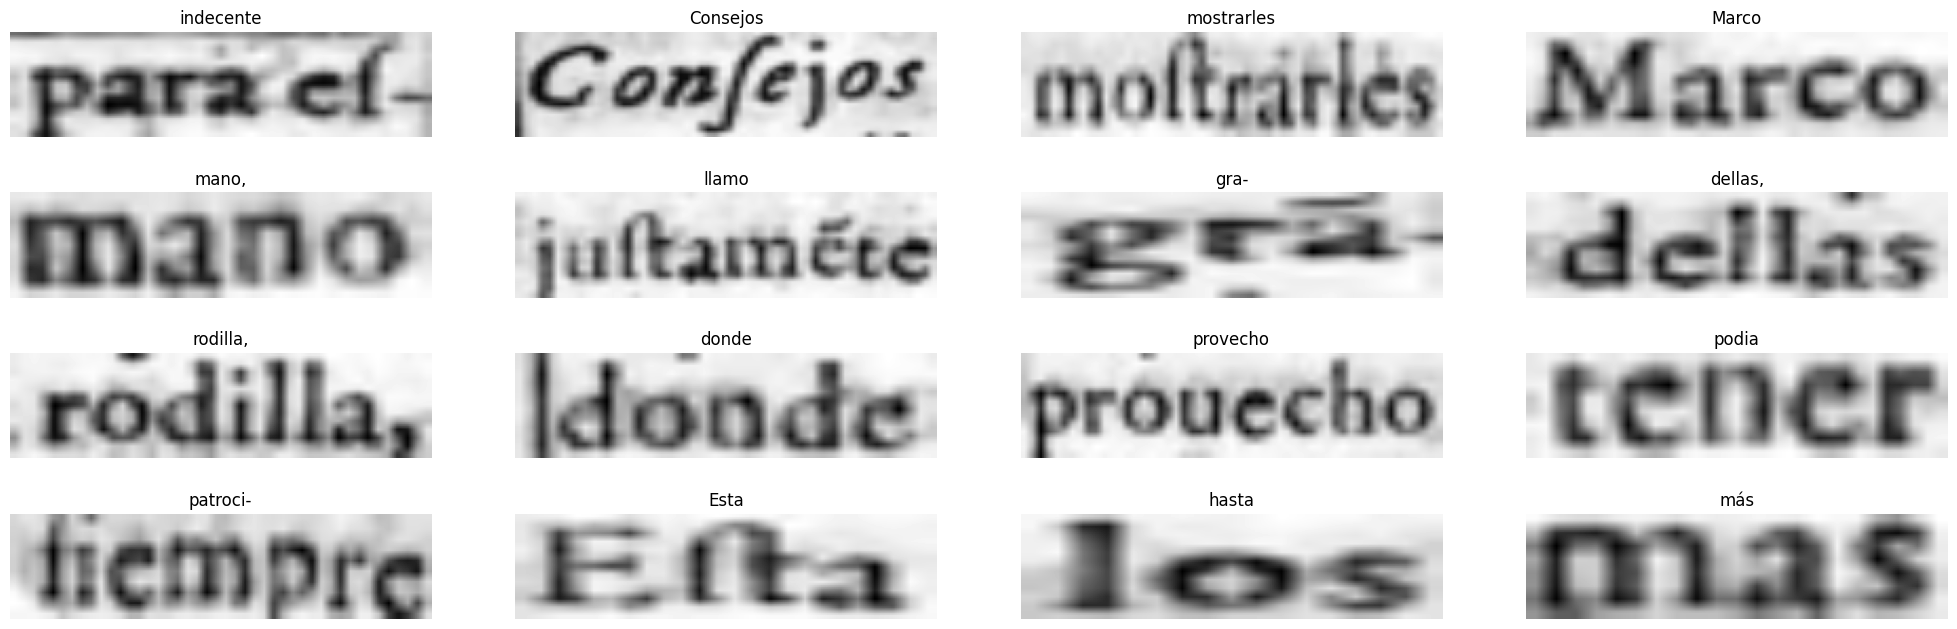

In [34]:
show_images(data=train_ds, cmap='gray')

# Model Definition

### Defines a custom Keras layer that computes and adds the Connectionist Temporal Classification (CTC) loss to the model for training sequence-to-sequence prediction tasks.

In [35]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

### Decodes the predicted labels from the OCR model, converting numeric values back to characters and removing unknown tokens to produce the final text output.

In [36]:
def decode_pred(pred_label):

    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability
    for each character. The function uses CTC decoding to decode the numeric labels back into their
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.

    Argument :
        pred_label : These are the model predictions which are needed to be decoded.

    Return:
        filtered_text : This is the list of all the decoded and processed predictions.

    '''

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

### This code defines a deep learning model for optical character recognition (OCR) using a combination of convolutional neural networks (CNNs) for feature extraction and bidirectional long short-term memory (LSTM) networks for sequence learning, concluding with a custom CTC loss layer for training.

In [37]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)


In [38]:
# Model Summary
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 100, 25, 64)          18496     ['max_pooling2d[0][0]']   

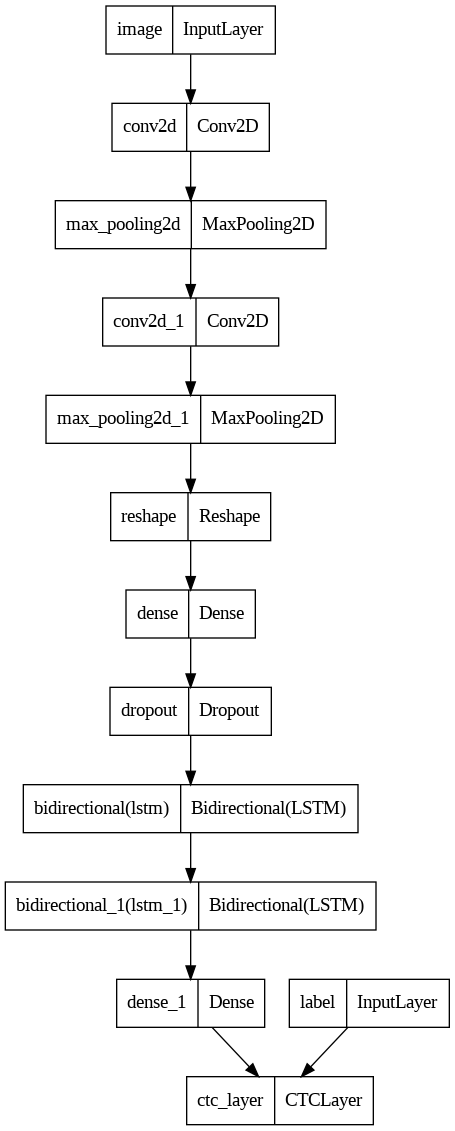

In [39]:
tf.keras.utils.plot_model(ocr_model)

### Compiles the OCR model with the Adam optimizer and trains it on the training dataset with validation, using early stopping and model checkpoint callbacks.

In [46]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/200
63/63 [==============================] - 12s 60ms/step - loss: 7.9857 - val_loss: 11.1524
Epoch 2/200
63/63 [==============================] - 2s 34ms/step - loss: 7.5751 - val_loss: 11.1102
Epoch 3/200
63/63 [==============================] - 2s 33ms/step - loss: 7.3893 - val_loss: 11.1578
Epoch 4/200
63/63 [==============================] - 3s 54ms/step - loss: 7.1332 - val_loss: 11.2362
Epoch 5/200
63/63 [==============================] - 2s 35ms/step - loss: 7.1141 - val_loss: 11.0595
Epoch 6/200
63/63 [==============================] - 2s 34ms/step - loss: 6.8456 - val_loss: 11.1952
Epoch 7/200
63/63 [==============================] - 2s 33ms/step - loss: 6.7681 - val_loss: 11.1718
Epoch 8/200
63/63 [==============================] - 2s 33ms/step - loss: 6.5055 - val_loss: 11.2804
Epoch 9/200
63/63 [==============================] - 3s 51ms/step - loss: 6.3581 - val_loss: 11.4245
Epoch 10/200
63/63 [==============================] - 2s 35ms/step - loss: 6.1363 - val_lo

### Creates an inference model from the trained OCR model for making predictions and prints the model summary.

In [47]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 12, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 50, 768)           0   

In [48]:
print(decode_pred(inference_model.predict(test_ds)))   #convert to test_ds

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


54/54 [==============================] - 2s 10ms/step
['elbrando', 'Aa', 'hubgas', 'eto', 'Peitencils,', '', 'tio', 'Conento', 'o', 'u,', 'ella', 'daa', 'aos', 'mala', 'muchos,', 'ha', '', 'destos,', 'dea', 'oporieon', 'huscar', 'admirays', 'segra', 'e', 'si', 'Caellanes', 'da', 'prro', 'geo', 'a', 'espirital,', '', 'hanis', 'Coistiano', 'quien', 'consegis', 'ciencia', 'i-', 'la', 'diencia', 'dado', 'cis,', 'reasedes', 'halleys', 'mtrad', 'al,', 'oros', 'Eitad,', 'dio', 'ri', 'o', 'pues', 'o', 'bn', 'mo', 'deviendo', 'revese', 'u', '', 'heredado', 'tantes', 'Cas', 'u', 'ba', 'cauoo', 'eo', 'dadosas', 'poerr', 'cordaos', 'si-', 'amuncian', 'gays', 'les', 'p', 'dis', 's', 'tabeys', 'i', 'u', 'esogerlos', 'se', 'cier-', 'bu', 'tato', 'nas', 'furstes', 'u,', 'dispesto', 'deas', 'atodas', 'buiera', 'pirandes', 'tal', 'ta', 'pa', 'sieo', 'mchos', 'P', 'qumnpo,', 'volntad', 'prcado', 'h', 'obligas', 'tan', 'oos', 'su', 'as', 'estima', 'ci', 'estas', 'les', 'iino', 'a', 'si', 'qual', 'ls', 'al

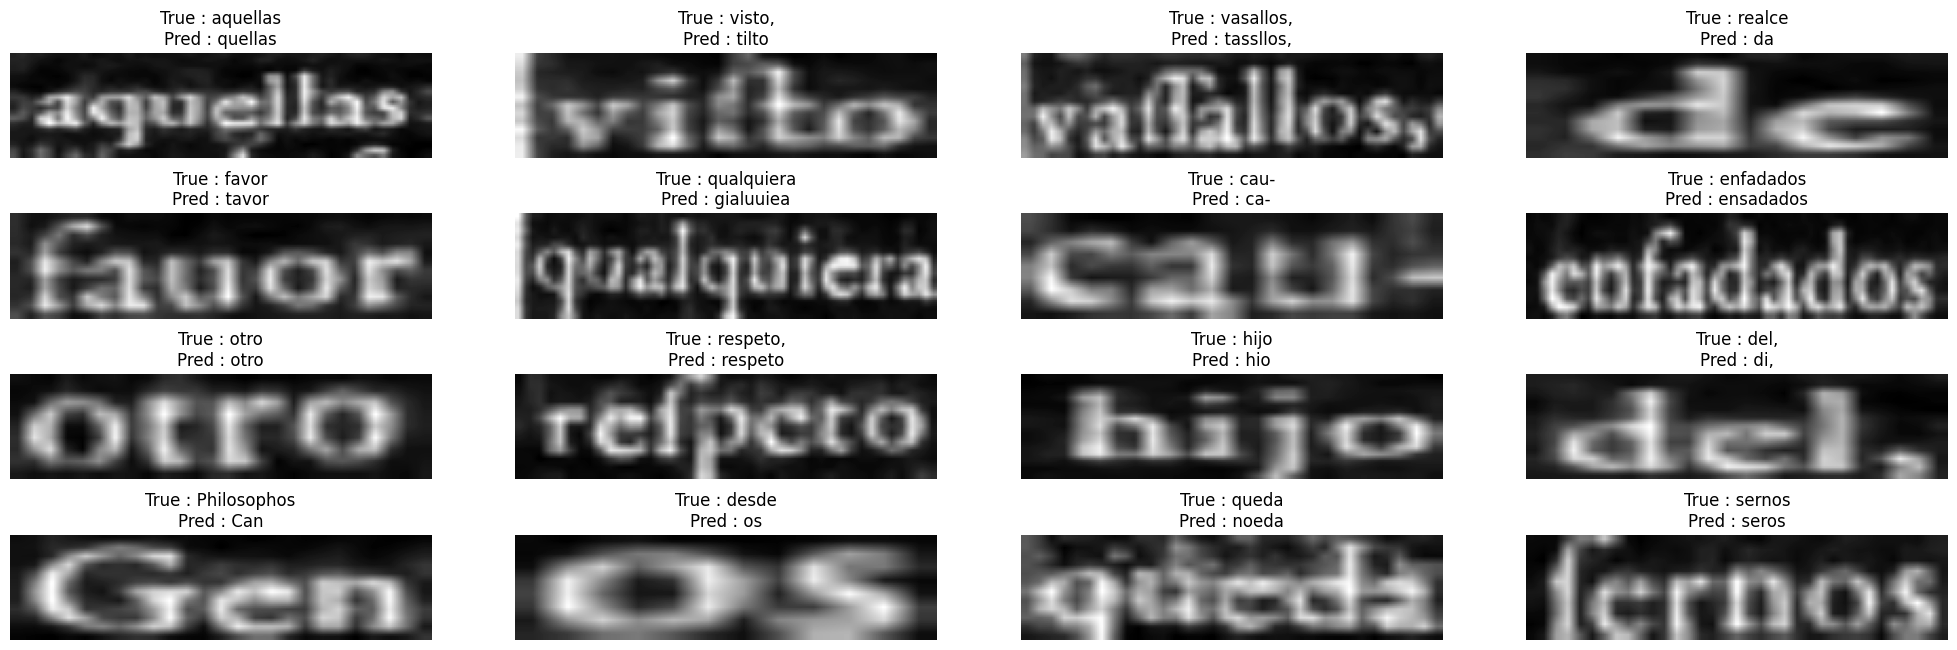

In [49]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

### Generates and decodes predictions from the inference model on the test dataset, printing the results in groups of 8 words per line.


In [50]:
decoded_predictions = decode_pred(inference_model.predict(test_ds))

# Print decoded predictions in groups of 8 words per line (You will have to figure out a better and ideal approach, this is just for sample)
words_per_line = 8
for i in range(0, len(decoded_predictions), words_per_line):
    print(' '.join(decoded_predictions[i:i+words_per_line]))

54/54 [==============================] - 1s 17ms/step
elbrando Aa hubgas eto Peitencils,  tio Conento
o u, ella daa aos mala muchos, ha
 destos, dea oporieon huscar admirays segra e
si Caellanes da prro geo a espirital, 
hanis Coistiano quien consegis ciencia i- la diencia
dado cis, reasedes halleys mtrad al, oros Eitad,
dio ri o pues o bn mo deviendo
revese u  heredado tantes Cas u ba
cauoo eo dadosas poerr cordaos si- amuncian gays
les p dis s tabeys i u esogerlos
se cier- bu tato nas furstes u, dispesto
deas atodas buiera pirandes tal ta pa sieo
mchos P qumnpo, volntad prcado h obligas tan
oos su as estima ci estas les iino
a si qual ls algos haed ren geos
a Princi a ocho os hatienda serirle pa-
p Tlladn has moetiendose prdrr  Semana reprutros
a, Soa prbresda exscosged, sucedio menos toca aos
Aabraba da a i proceda da a g
de se oios bupretde ocasiones, derramar cenn certi
humperador mas mo  pu ta mina nu
ua, gu, u serr vi entganos atoridad, sino
 su dia rea  cantes a santi-
So Dios 